In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Simulator

The SEM simulator 4 building blocks: _nodes, edges, graphs, parameterizers_

1. _nodes_ defined by i) name, ii) parents, iii) state funtion, iv) output function
2. _edges_ defined by i) parent-child node pair; ii) edge function.
3. _graphs_ defined by its set of nodes and edges (via an adjacency matrix)
4. Functions require paremters (e.g. coefficients of a linear state function). _Parameterizers_ generate a set of simulation parameters at each run. Via parameterizers, we apply simulation partial-restrictions, while randomizing the rest (e.g. generate normally distributed data via any linear model coefficients, or treatment interactions with any arbitrary edge function) 

## Nodes

Create a source node:

In [4]:
from rad_sim.sem.graph_objects import Node

# instantiate
n1 = Node(name='X1', parents=[])
# set output function (dtype)
n1.set_output_function(
    function_name='gaussian_noise'
).set_output_params(
    params={'rho': 0}
)
# sample: size is determined because it's source node
n1.calc_state(size=1000)
n1.calc_output()

data = pd.DataFrame({'X1': n1.value['output']})
# printing first 5 rows
data.head()

,X1
0,-0.067821
1,-0.611097
2,1.222093
3,1.404958
4,0.031833


**Note** for source nodes, standard gaussian normal is sampled from.

create a child node (binary)

In [5]:
# instantiate
n2 = Node(name='X2', parents=['X1'])
# set state function
n2.set_state_function(
    function_name='linear'
).set_state_params(
    params={'coefs':[1.5]}
)
# set output function (dtype)
n2.set_output_function(
    function_name='bernoulli'
).set_output_params(
    params={'gamma': 1, 'rho':0}
)
# sample: size is determined because it's source node
n2.calc_state(inputs=data)
n2.calc_output()

data['X2'] = n2.value['output']
# printing first 5 rows
data.head()

,X1,X2
0,-0.067821,1
1,-0.611097,0
2,1.222093,1
3,1.404958,1
4,0.031833,1


visualize (for the fun of it)

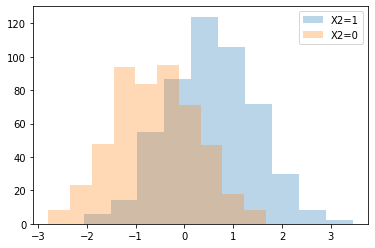

In [6]:
plt.hist(data[data.X2==1].X1, alpha=0.3, label='X2=1')
plt.hist(data[data.X2==0].X1, alpha=0.3, label='X2=0')
plt.legend()
plt.show()

**Remarks**

- state functions: _linear, linear+interactions_.
- output functions: _continuous with Gaussian noise, bernoulli_. any type of data can be simulated using state value

## Edges

create and edge between `X1` and `X2`: output of `X1` passes through edge before going to `X2`

In [ ]:
from rad_sim.sem.graph_objects import Edge

# instantitate
e1 = Edge(parent='X1', child='X2')
# set function and params
e1.set_function(
    function_name='sigmoid'
).set_function_params(
    function_params={'alpha': 1, 'beta': 1.9, 'gamma': 1, 'tau': 1, 'rho': 0}
)
# map
edge_output = e1.map(array=data['X1'])

# give this as the input to X2
n2.calc_state(
    inputs=pd.DataFrame({'X1': edge_output})
)
data['X2'] = n2.calc_output()

plot histogram again

In [ ]:
plt.hist(data[data.X2==1].X1, alpha=0.3, label='X2=1')
plt.hist(data[data.X2==0].X1, alpha=0.3, label='X2=0')
plt.legend()
plt.show()

**Remarks**

- edge functions are: _identity (no change), sigmoid and Gaussian RBF (for continuous input), Beta noise (for binary input)_

## Graphs and parameterizers

Graphs simulate nodes and edges given an adjacency matrix and the set of parameters

In [ ]:
from rad_sim.sem.graph_objects import BaseGraph

graph = BaseGraph()
graph.set_nodes(nodes_list=[
    {
        'name': 'A1',
        'parents': [],
        'output_type': 'continuous',
        'state_function': 'linear',
        'output_function': 'gaussian_noise',
        'state_params': {},
        'output_params': {'rho': 0.02}
    },
    {
        'name': 'A2',
        'parents': [],
        'output_type': 'continuous',
        'state_function': 'linear',
        'output_function': 'gaussian_noise',
        'state_params': {},
        'output_params': {'rho': 0.02}
    },
    {
        'name': 'B1',
        'parents': ['A1', 'A2'],
        'output_type': 'binary',
        'state_function': 'linear',
        'output_function': 'bernoulli',
        'state_params': {'coefs': np.array([1, 1])},
        'output_params': {'rho': 0.02, 'gamma': 0}
    }
])
edge_param = {'alpha': 1, 'beta': 0, 'gamma': 0, 'tau': 1, 'rho': 0.02}
graph.set_edges(
    adj_matrix=pd.DataFrame(
        [
            [0, 0, 1],
            [0, 0, 1],
            [0, 0, 0]
        ],
        columns=['A1', 'A2', 'B1'],
        index=['A1', 'A2', 'B1']
    ),
    function_specs={
        'A1 -> B1': {'function_name': 'sigmoid', 'function_params': edge_param},
        'A2 -> B1': {'function_name': 'sigmoid', 'function_params': edge_param}
    }
)
data = graph.sample(size=300)
print(data)

## Graphs and parameterizers

Graphs simulate nodes and edges given an adjacency matrix and the set of parameters

In [22]:
from rad_sim.sem.graph_objects import BaseGraph

graph = BaseGraph()
graph.set_nodes(nodes_list=[
    {
        'name': 'A1',
        'parents': [],
        'output_type': 'continuous',
        'state_function': 'linear',
        'output_function': 'gaussian_noise',
        'state_params': {},
        'output_params': {'rho': 0.02}
    },
    {
        'name': 'A2',
        'parents': [],
        'output_type': 'continuous',
        'state_function': 'linear',
        'output_function': 'gaussian_noise',
        'state_params': {},
        'output_params': {'rho': 0.02}
    },
    {
        'name': 'B1',
        'parents': ['A1', 'A2'],
        'output_type': 'binary',
        'state_function': 'linear',
        'output_function': 'bernoulli',
        'state_params': {'coefs': np.array([1, 1])},
        'output_params': {'rho': 0.02, 'gamma': 0}
    }
])
edge_param = {'alpha': 1, 'beta': 0, 'gamma': 0, 'tau': 1, 'rho': 0.02}
graph.set_edges(
    adj_matrix=pd.DataFrame(
        [
            [0, 0, 1],
            [0, 0, 1],
            [0, 0, 0]
        ],
        columns=['A1', 'A2', 'B1'],
        index=['A1', 'A2', 'B1']
    ),
    function_specs={
        'A1 -> B1': {'function_name': 'sigmoid', 'function_params': edge_param},
        'A2 -> B1': {'function_name': 'sigmoid', 'function_params': edge_param}
    }
)
data = graph.sample(size=300)
print(data)

TypeError: set_function_params() got an unexpected keyword argument 'function_params'